In [113]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from align import AlignDlib
from imutils import face_utils
import dlib
import pickle

from keras.models import load_model,model_from_json
import tensorflow as tf
%matplotlib inline


In [114]:
def load_final_model():
    '''
    Loads the Final Model saved in the fir 'final_model'
    '''
    # load json and create model
    json_file = open('final_model/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn4_small2 = model_from_json(loaded_model_json,custom_objects={'tf': tf})
    # load weights into new model
    nn4_small2.load_weights("final_model/model.h5")
    print("[INFO]:Loaded model from disk")
    return nn4_small2

In [115]:
model = load_final_model()
print(type(model))
#model.summary()

[INFO]:Loaded model from disk
<class 'tensorflow.python.keras.engine.training.Model'>


In [116]:
def load_image(path):
    '''
    OBJECTIVE: Load image 
    
    Returns:
    RGB image
    '''
    img = cv2.imread(path, 1)
    return img[...,::-1] #Convert to RGB and return

In [117]:
def align_image(img,bb):
    '''
    OBJECTIVE: Align a face based using DLIB model
    
    Parameter:
    test - RGB Image
    bb - bounding box around the person to be searched
    
    Returns:
    Aligned face
    
    '''
    
    # return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    if(bb):
        return alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    else:
        return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [118]:

def generate_encoding(img,bb):
    '''
    OBJECTIVE: Generates an 128D encoding based on the loaded model
    
    Parameter:
    test - RGB Image
    bb - bounding box around the person to be searched
    
    Returns:
    embedded-128D encoding
    '''
    embedded = np.zeros((1, 128)) #Declare a placeholder variable
    #print(m.image_path())    
    #img = load_image(path)
    img = align_image(img,bb) #Align the image 
    #plt.imshow(img)
    # scale RGB values to interval [0,1]
    img = (img / 255).astype(np.float32)
    # obtain embedding vector for image
    embedded= nn4_small2.predict(np.expand_dims(img, axis=0))[0] #generate encoding
    return embedded

In [119]:
def distance(emb1, emb2):
    '''
    OBJECTIVE: Compute and return L2 squared distance
    '''
    return np.sum(np.square(emb1 - emb2))

In [120]:
def recognise(test,bb):
    '''
    OBJECTIVE: Search the database for matching faces based on lowest distance
    
    Parameter:
    test - RGB Image
    bb - bounding box around the person to be searched
    
    Returns:
    min_dist - Minimum distance on the 128D space 
    identity - str identity of person matched as stored in database, 0 if no person found
    '''
    
    threshold = 0.75 #Set according to the Facenet Paper
    test_em=None
    test_em = generate_encoding(test,bb) #Generate the 128D encoding
    min_dist = 100 #Set a max min distance

    for (name, db_enc) in database.items(): #Checks for each entries in the database

        dist = distance(test_em,db_enc)

        if dist < min_dist:
            min_dist = dist
            identity = name


    if min_dist > threshold:
        identity=0
    #       print(min_dist,"Not in the database.")
    else:
    #       print (min_dist,"it's " + str(identity) )
        pass


    return min_dist, identity

In [121]:
def make_database(entries):
    '''
    OBJECTIVE: Generate Database
    
    Parameters:python dictionary with the keys as id and values and image path 
    '''
    print('[INFO]:Creating New Database....')    
    for (i,j) in entries.items():
        if i not in database.keys():
            img = load_image(j)
            #print(i)
            database[i] = generate_encoding(img,0)
           
    return database
    print('[INFO]:New Database Creation Completed!')

In [122]:
def face_recognition(path):
    
    '''
    OBJECTIVE: Perform Face Recognition on Images
    
    Parameters:
    path-image path
    
    '''
    print('Recognising faces......')
    rgbImg = load_image(path) #Load the RGB Image from the path
    
    #detector is defined in the main function
    res = detector(rgbImg, 1) #Get all the bounding boxes af all the faces dectected in the image
    
    
    for bb in res: #Run for each bounding box,i.e for each person detected
        
        (x, y, w, h) = face_utils.rect_to_bb(bb) #Get the coordinates from the bounding box
        # cv2.rectangle(rgbImg, (x, y), (x + w, y + h), (255, 255, 0), 2)
        dist , id = recognise(rgbImg,bb) #Returns  the minimum distance and the identity as stored in the database
        # plt.imshow()
        
        if (id): #If person is detected
            plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
            plt.text(bb.left(), (bb.bottom()+bb.height() / 2) , id,color='black',size='large',backgroundcolor='white')
            print('Face Recognition Complete!')
        else:
            print("Face not detected!")
    plt.imshow(rgbImg)
    

In [123]:
def live_feed():
    
    '''
    OBJECTIVE: Perform Face Recognition on Live Video    
    '''
    cap = cv2.VideoCapture(0)
    
    while True:
            start_frame_number = 100
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
            ret, img = cap.read()
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            subjects = detector(rgbImg, 1)

            for subject in subjects:
                (x, y, w, h) = face_utils.rect_to_bb(subject)
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 2)
                dist , id = recognise(rgbImg,subject)
                if(id):
                    cv2.putText(img, "Face : " + str(id), (x, y - 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)
                else:
                    cv2.putText(img, "Face : " + 'Not Recognised', (x, y - 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)
            cv2.imshow('Recognizing faces', img)
            if cv2.waitKey(1) == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [128]:
if __name__ == '__main__':
    '''
    Main function
    '''
    detector = dlib.get_frontal_face_detector()
    # Initialize the OpenFace face alignment utility
    alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')
    nn4_small2 = load_final_model()    
    
    database={}
    
    count=0
    entries={}
    entries['Hrishi']='images/hrishi1.jpg'
    entries['Shaima']='images/shaima1.jpg'
    entries['Debanshi']='images/debanshi3.jpg'
    
    try:
        pkl_file = open('data_file2.pkl', 'rb')
        database = pickle.load(pkl_file)
        print("Found")
        
    except FileNotFoundError:
        print("File not accessible")
        make_database(entries)
        new_database(database)
        
    finally:
        pkl_file.close()
   
        
       #     print('True')
       # else:
    #make_database(entries) 
    #val=input("Do you want to upload new entry to the database?")
    #if (val==yes):
   #     entries["Dada"]='images/dada1.jpeg'
    #    make_database(entries)
    #This make databse function is called everytime on calling main
    #In a sepeareate cell call this function once and sve thefinal database ina file 
    #jete pisot jeitya ami main function tu call kori khi first check koribo file tu ase ne nai
    #file tu thakile tare pora dn tu read koribo
    #aru nathakile ei make dtabase function tu call koribo
    #bujisa? 
    

[INFO]:Loaded model from disk
Found


In [129]:
database


{'Hrishi': array([ 0.05080647,  0.13044083,  0.17319311,  0.1759544 , -0.02169098,
         0.08694606,  0.00989091, -0.15438405,  0.09453103, -0.08828596,
         0.05989083, -0.07334646, -0.01253596,  0.03583389,  0.08072117,
         0.0147185 ,  0.01570261,  0.11713654, -0.13038254, -0.05772687,
         0.11378688, -0.03141626, -0.02964375,  0.10746636,  0.17540973,
        -0.21261355, -0.18923888,  0.05328912, -0.03500322,  0.11006836,
         0.13101584,  0.1310665 , -0.02277093,  0.11798619,  0.08386278,
         0.00312751,  0.04275515, -0.00825244,  0.07066341, -0.12430692,
         0.01609473, -0.04145231,  0.1272108 , -0.16226074,  0.0844494 ,
        -0.16177946, -0.00366811,  0.00087382, -0.03715397,  0.01258474,
         0.06361692, -0.0075005 ,  0.11552258,  0.0158539 ,  0.01956377,
         0.03112103, -0.0648507 , -0.02260342,  0.00372557, -0.12444879,
        -0.07329956,  0.06142073, -0.07640541, -0.1646231 , -0.02289924,
         0.2666388 ,  0.03053961, -0.0867

In [125]:
def new_database(database):
    f = open("data_file2.pkl","wb")
    pickle.dump(database,f)
   
    f.close()

Recognising faces......
Face Recognition Complete!
Face Recognition Complete!
Face Recognition Complete!


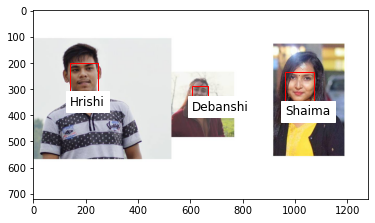

In [130]:
face_recognition('images/New Project.jpg')

In [131]:
live_feed()